In [1]:
import numpy as np
import random
import itertools
import math
import matplotlib.pyplot as plt
from qiskit.quantum_info import DensityMatrix, partial_trace,random_statevector
from qiskit import QuantumCircuit
import bluequbit
from qiskit.visualization import plot_histogram
import ast

def get_cyclic_permutation(permutation):
    '''
    input: arbitary permutation of tokens in complete graph:list
    output: cyclic permutation equivalent of the input:list of lists
    '''
    pi=permutation
    cyclic_permutation=[]
    n=len(pi)
    not_in_cycle=list(range(n))
    while len(not_in_cycle)!=0:
        cycle=[]
        start=not_in_cycle[0]
        current=start
        cycle.append(start)
        not_in_cycle.remove(start)
        final=-1
        while final != start:
            current=permutation[current]
            cycle.append(current)
            if(current in not_in_cycle):
                not_in_cycle.remove(current)
            final=current
        cyclic_permutation.append(cycle)
    cyclic=[]
    for i in cyclic_permutation:
        length=len(i)
        if(length>2):
            cyclic.append(i[:-1])
    return(cyclic)
def Get_Routing_via_matching(cyclic_permutation):
    '''
    input:cyclic permutations: list of lists
    output: 2 step swaps that is equivalent to routing via matching 2 list of list(list of swaps)
    '''
    layer_1=[]
    layer_2=[]
    for cycle in  cyclic_permutation:
        length=len(cycle)
        for j in range(int(len(cycle)/2)):
            layer_1.append([cycle[j],cycle[length-j-1]])
            if(cycle[j+1]!=cycle[length-j-1]):
                layer_2.append([cycle[j+1],cycle[length-j-1]])
    return(layer_1,layer_2)

def old_causaly_cover_nodes(M,i,j):##edges=M
    '''
    input: M=random matching for the complete graph
           i=initial node n>=i,j>=0 int
           j=final node 
    output:boolean:true: iand j are causaly cover
                   false: i and j are not causaly covered
    '''
    path=[i]
    cover=False
    for matching in M: ##if you think about it M is nothing but random matching in our complete graph
        for i in matching:
            current=path[-1]
            if(i[0]==current):
                path.append(i[1])
                if(i[1]==j):
                    cover=True
                break
            elif(i[1]==current):
                path.append(i[0])
                if(i[0]==j):
                    cover=True
                break
        if(cover==True):
            # print("path for causaly cover=",path)
            return cover
    return cover
def causaly_cover_nodes(M,i,j):##edges=M
    '''
    input: M=random matching for the complete graph
           i=initial node n>=i,j>=0 int
           j=final node 
    output:boolean:true: iand j are causaly cover
                   false: i and j are not causaly covered
    '''
    covered_set=[i]
    cover=False
    for matching in M: ##if you think about it M is nothing but random matching in our complete graph
        for k in matching:
            new_covered=[]
            for l in covered_set:
                current=l
                if(k[0]==current):
                    new_covered.append(k[1])
                    if(k[1]==j):
                        cover=True
                        break
                elif(k[1]==current):
                    new_covered.append(k[0])
                    if(k[0]==j):
                        cover=True
                        break
            covered_set=covered_set+new_covered
            if(cover==True):
                # print("path for causaly cover=",path)
                return cover
    return cover

def causaly_cover_graph(M,n):
    nodes=list(range(n))
    ##get all the possible pair combination for nodes:
    permutation=list(itertools.permutations(nodes,2))
    for pairs in permutation:
        is_causaly_cover=causaly_cover_nodes(M,pairs[0],pairs[1])
        if(is_causaly_cover== False):
            return(False,pairs)
    return(True,(-1,-1))
def create_M(pi):
    ''' 
    input: random/ arbitary permutations
    output:return all the matching generated for this permutations using 2 step routing algorithm
    '''
    ##pass all these permutation to get two step routing 
    M=[]
    for i in range(len(pi)):
        cyclic_permutation=get_cyclic_permutation(pi[i])
        O,E=Get_Routing_via_matching(cyclic_permutation)
        M.append(O)
        M.append(E)
    return M


In [2]:
def initialize_zero(qc,n):
    for i in range(n):
        qc.initialize([1,0],i)
    return qc

def initialize_R_product_state(q,n):
    for i in range(n):
        q.initialize(random_statevector(2).data,i)
    return(q)

def random_clifford(qc,n):
    qubits_list=list(range(n))
    for i in range(500):
        choice=random.choices(['s','h','cnot','i'])[0]
        qbit=random.choices(qubits_list)[0]
        if choice=='s':
            qc.s(qbit)
        elif choice=='h':
            qc.h(qbit)
        elif choice=='i':
            True
        elif choice=='cnot':
            c=qubits_list.copy()
            c.remove(qbit)
            control_bit=random.choices(c)[0]
            order=[control_bit,qbit]
            random.shuffle([control_bit,qbit]) ## randomize the cont order
            qc.cx(order[0],order[1])
    return qc

def random_clifford_with_depth(qc,n,depth):
    qubits_list=list(range(n))
    gates=[]
    for i in range(depth):
        un_used_qubits=qubits_list.copy()
        gates_added={}
        while len(un_used_qubits)>=1:
            qbit=random.choice(un_used_qubits)
            choice=random.choices(['s','h','cnot'])[0]
            un_used_qubits.remove(qbit)
            if choice=='s':
                qc.s(qbit)
                gates_added[qbit]='s'
            elif choice=='h':
                qc.h(qbit)
                gates_added[qbit]='h'
            elif choice=='cnot':
                if(un_used_qubits!=[]):
                    control_bit=random.choices(un_used_qubits)[0]
                    order=[control_bit,qbit]
                    random.shuffle(order)
                    qc.cx(order[0],order[1])
                    un_used_qubits.remove(control_bit)
                    gates_added[str(order)]='cnot'

        gates.append(gates_added)
    return qc,gates

def random_Cnot_permutation(qc,n):
    pi=[]
    nodes=list(range(n))
    for i in range(int(math.log(n,2))):
        pi.append(list(random.sample(nodes,n)))
    M=create_M(pi)
    ## now add the cnot gate layers according to the matching. 
    for i in M:
        for cnots in i:
            qc.cx(cnots[0],cnots[1])
        ## after each layer of cnots add random S,H gates to all other qubits
        for i in range(n):
            choice=random.choices(['s','h','i'])[0]
            if choice=='s':
                qc.s(i)
            elif choice=='h':
                qc.h(i)
            elif choice=='i':
                True
    return qc

def t_layer(qc,n):
    for i in range(n):
        qc.t(i)
    return qc

def initialize_t_state(qc,n):
    for i in range(n):
        qc.h(i)
        qc.t(i)
        qc.h(i)
    return qc

def get_r_tildae_qiskit(qc,partition):
    rho= DensityMatrix.from_instruction(qc) ##get the state vector of the system
    # print(state)
    rho_a=partial_trace(state=rho,qargs=partition)  ##rho_a is the reduced density matrix for the first a subsystem A(as the paper has divided the whole system into A and B subsystem)
    eigenvalues=np.linalg.eigvals(rho_a.data) ##entanglement spectrum is the set of the eigen values of the reduced density matrix
    ES=sorted(eigenvalues,reverse=True)
    ES_real=[i.real for i in ES ]
    lambd=ES_real
    r_k_tilda=[]
    for i in range(1,len(lambd)-1):
        del_k=lambd[i-1]-lambd[i]
        del_k_P1=lambd[i]-lambd[i+1]
        r_k_tilda.append(min(del_k,del_k_P1)/max(del_k,del_k_P1))
    r_mean=np.mean(r_k_tilda)
    return r_mean

def rdm_qiskit(qc,partition):
    rho= DensityMatrix.from_instruction(qc) ##get the state vector of the system
    # print(state)
    rho_a=partial_trace(state=rho,qargs=partition)  ##rho_a is the reduced density matrix for the first a subsystem A(as the paper has divided the whole system into A and B subsystem)
    return rho_a

def brick_1D_add_4_layer(qc,n): 
    layer=0
    for i in range(0,n,2):
        pair=[i,i+1]
        random.shuffle(pair)
        qc.cx(pair[0],pair[1])
    for i in range(n):
        choice=random.choices(['s','h','i'])[0]
        if choice=='s':
            qc.s(i)
        elif choice=='h':
            qc.h(i)
        elif choice=='i':
            True
    for i in range(1,n-1,2):
        pair=[i,i+1]
        random.shuffle(pair)
        qc.cx(pair[0],pair[1])
    # qc.cnot(0,n-1)
    for i in range(n):
        choice=random.choices(['s','h','i'])[0]
        if choice=='s':
            qc.s(i)
        elif choice=='h':
            qc.h(i)
        elif choice=='i':
            True
    return qc

def rdm_blue_qubit(qc,partition=0):
    n=qc.num_qubits
    if (partition==0):
        partition=list(range(int(n/2)))
    ## this loop for arranging the qubits incase the qubits for RDM is not sequencial
    qc_copy=qc.copy()
    partition.sort()
    for i in range(len(partition)):
        if(i!=partition[i]):
            qc_copy.swap(i,partition[i])
    qc_copy.measure_all()
    ##simulate using blue qubit
    bq=bluequbit.init("bnK9f3RMNBjj2Fi3BqyBbcyFLHS8pLFc")
    result=bq.run(qc_copy,job_name="testing_1")
    statevector=result.get_statevector()
    state_matrix=statevector.reshape(2**int(n/2),2**int(n/2))
    rdm=np.matmul(state_matrix,np.conj(state_matrix).T)
    return rdm,statevector

def get_r_tildae_rdm(rdm):
    eigenvalues=np.linalg.eigvals(np.matrix(rdm)) ##entanglement spectrum is the set of the eigen values of the reduced density matrix
    ES=sorted(eigenvalues,reverse=True)
    ES_real=[i.real for i in ES ]
    lambd=ES_real
    r_k_tilda=[]
    for i in range(1,len(lambd)-1):
        del_k=lambd[i-1]-lambd[i]
        del_k_P1=lambd[i]-lambd[i+1]
        r_k_tilda.append(min(del_k,del_k_P1)/max(del_k,del_k_P1))
    r_mean=np.mean(r_k_tilda)
    return r_mean

def get_r_tildae(qc,partition,simulator):
    n=qc.num_qubits
    if (partition==0):
        partition=list(range(int(n/2)))
    if(simulator=='qiskit'):
        rdm=rdm_qiskit(qc,partition)
        r_tildae=get_r_tildae_rdm(rdm)
        return(r_tildae,rdm)
    elif(simulator=='bq'):
        rdm,state_vector=rdm_blue_qubit(qc,partition)
        r_tildae=get_r_tildae_rdm(rdm)
        return(r_tildae,rdm,state_vector)

In [224]:
n=16
depth=30
qc=QuantumCircuit(n)
# qc=initialize_t_state(qc,n)
# qc=initialize_zero(qc,n)
r_tildae_list=[]
gates_list=[]
 
for i in range(n):
    qc.h(i)
    qc.t(i)
    qc.h(i)
state_vectors=[]
for i in range(depth):
    qc,gates=random_clifford_with_depth(qc,n,1)
    r_tildae_qiskit,rdm_from_qiskit,statevector=get_r_tildae(qc,partition=list(range(int(n/2))),simulator='bq')
    state_vectors.append(statevector)
    # r_tildae_qiskit,rdm_from_qiskit=get_r_tildae(qc,partition=list(range(int(n/2))),simulator='qiskit')
    r_tildae_list.append(r_tildae_qiskit)
    gates_list.append(gates)


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NUXphZpaSyvTZikt, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:43:43 UTC, cost: $0.00, run time: 5 ms, queue time: 27 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ulTuUV4zeOUhNHCW, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:43:48 UTC, cost: $0.00, run time: 6 ms, queue time: 26 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: sWSujs0STXoKCpPc, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:43:51 UTC, cost: $0.00, run time: 7 ms, queue time: 22 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ZJm0zsRHQaao2VmK, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:43:56 UTC, cost: $0.00, run time: 7 ms, queue time: 23 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ifozX9TclMAVdIVk, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:44:01 UTC, cost: $0.00, run time: 8 ms, queue time: 29 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: F8pYdaOvbO50umWx, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:44:04 UTC, cost: $0.00, run time: 8 ms, queue time: 27 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ZHkSMILaftgieDab, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:44:10 UTC, cost: $0.00, run time: 8 ms, queue time: 25 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dfAwsnIBHsTi7zPw, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:44:14 UTC, cost: $0.00, run time: 10 ms, queue time: 28 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: q59iYEv0fE2u5jpi, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:44:18 UTC, cost: $0.00, run time: 9 ms, queue time: 28 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NzEzaHPeIXIaSlV2, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:44:22 UTC, cost: $0.00, run time: 10 ms, queue time: 27 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5EHkKlZsci8VD7fd, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:44:25 UTC, cost: $0.00, run time: 11 ms, queue time: 31 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ahyQHV2Hw8CAQuJS, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:44:29 UTC, cost: $0.00, run time: 11 ms, queue time: 42 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mmHi25BdW1Bj92Xu, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:44:34 UTC, cost: $0.00, run time: 12 ms, queue time: 27 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: qwSaiXwMXfq5UDhk, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:44:37 UTC, cost: $0.00, run time: 13 ms, queue time: 23 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6GAnt6eOuJvTtNaj, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:44:42 UTC, cost: $0.00, run time: 13 ms, queue time: 26 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bDC5W1mIjuZQAlSK, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:44:45 UTC, cost: $0.00, run time: 14 ms, queue time: 24 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: QXFvZwG6mGzP3fWA, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:44:49 UTC, cost: $0.00, run time: 14 ms, queue time: 30 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Z4vpDmY0HkD48QcY, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:44:53 UTC, cost: $0.00, run time: 18 ms, queue time: 25 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: x8M1h6jV9umBB6U0, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:45:00 UTC, cost: $0.00, run time: 16 ms, queue time: 28 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: I2ko6zH1sJNMcGbS, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:45:04 UTC, cost: $0.00, run time: 15 ms, queue time: 26 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zMwtzWOjmQHe83ca, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:45:08 UTC, cost: $0.00, run time: 16 ms, queue time: 31 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: z311Qc3HW5TXNQDi, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:45:11 UTC, cost: $0.00, run time: 19 ms, queue time: 27 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: aqwhuTHKSbcRl68n, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:45:15 UTC, cost: $0.00, run time: 19 ms, queue time: 27 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CVrY3Q7Yb6k50FP1, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:45:19 UTC, cost: $0.00, run time: 18 ms, queue time: 79 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9tGrVkUIt7NHfHfb, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:45:23 UTC, cost: $0.00, run time: 19 ms, queue time: 27 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: BJB0SfZWVm5jTBEU, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:45:26 UTC, cost: $0.00, run time: 20 ms, queue time: 28 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NinkZzVovRBzkn9r, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:45:30 UTC, cost: $0.00, run time: 20 ms, queue time: 31 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NOb12wlkBoZxgRGR, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:45:34 UTC, cost: $0.00, run time: 22 ms, queue time: 27 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SDn0NqyWlQ0dJMKK, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:45:39 UTC, cost: $0.00, run time: 21 ms, queue time: 28 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: x7MDrHu4S1ig2vRP, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:45:43 UTC, cost: $0.00, run time: 22 ms, queue time: 28 ms, num qubits: 16


In [225]:
for i in range(n):
    qc.t(i)
# qc.t(int(n/2))
# for i in range(0,n,3):
#     qc.t(i)
depth=70
for i in range(depth):
    qc,gates=random_clifford_with_depth(qc,n,1)
    # r_tildae_qiskit,rdm_from_qiskit=get_r_tildae(qc,partition=list(range(int(n/2))),simulator='qiskit')
    r_tildae_qiskit,rdm_from_qiskit,statevector=get_r_tildae(qc,partition=list(range(int(n/2))),simulator='bq')
    r_tildae_list.append(r_tildae_qiskit)
    state_vectors.append(statevector)
    gates_list.append(gates)

[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ma7B4pUMg4BOpQsJ, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:45:46 UTC, cost: $0.00, run time: 25 ms, queue time: 27 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wryy1fwV8DwkX9gt, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:45:49 UTC, cost: $0.00, run time: 23 ms, queue time: 27 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kx8NWvg6HSTQ4LPn, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:45:53 UTC, cost: $0.00, run time: 25 ms, queue time: 26 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: vOdP3gcotIRJe92F, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:45:56 UTC, cost: $0.00, run time: 25 ms, queue time: 29 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6v04f41QmulBHzIi, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:46:01 UTC, cost: $0.00, run time: 25 ms, queue time: 26 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Vfg08SRVKUFbMnCE, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:46:04 UTC, cost: $0.00, run time: 25 ms, queue time: 30 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 7GTl6XMiuy7RM0Bb, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:46:08 UTC, cost: $0.00, run time: 27 ms, queue time: 37 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: a3g18qutWHJSITO8, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:46:12 UTC, cost: $0.00, run time: 26 ms, queue time: 34 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 01vKz0DUcOcWDW0B, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:46:18 UTC, cost: $0.00, run time: 28 ms, queue time: 31 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: U2SDBNeLsUo6rRgx, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:46:21 UTC, cost: $0.00, run time: 28 ms, queue time: 30 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 7A933pl7n93ZCCxN, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:46:25 UTC, cost: $0.00, run time: 29 ms, queue time: 30 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: hq0NTp8ipwsCMlLT, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:46:29 UTC, cost: $0.00, run time: 28 ms, queue time: 29 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: qp7HDQ8h4jazFzRg, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:46:33 UTC, cost: $0.00, run time: 29 ms, queue time: 38 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: tw20ZMf6XLInY4dC, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:46:36 UTC, cost: $0.00, run time: 30 ms, queue time: 29 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: DfKQhaf1HrNI1sAP, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:46:40 UTC, cost: $0.00, run time: 30 ms, queue time: 28 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Ljw2YhLTwPpbtqlc, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:46:43 UTC, cost: $0.00, run time: 38 ms, queue time: 30 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: i1YBhpRLoYCYe7nz, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:46:47 UTC, cost: $0.00, run time: 39 ms, queue time: 29 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: rEBq3AdGX64VxPsf, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:46:51 UTC, cost: $0.00, run time: 32 ms, queue time: 34 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: xLOtmueDAqQ5V671, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:46:56 UTC, cost: $0.00, run time: 32 ms, queue time: 32 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: hL50lFv7VVMkutny, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:46:59 UTC, cost: $0.00, run time: 37 ms, queue time: 32 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: qAQpEeXSMi1oUvIK, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:47:03 UTC, cost: $0.00, run time: 34 ms, queue time: 35 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SUUVlUvLpHbvpy1w, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:47:06 UTC, cost: $0.00, run time: 34 ms, queue time: 31 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: HbAcU6GXKWfH5Gah, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:47:10 UTC, cost: $0.00, run time: 35 ms, queue time: 30 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mhAseEHD1Gr1i3W5, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:47:14 UTC, cost: $0.00, run time: 35 ms, queue time: 33 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: UoEvFPfGVgntejGz, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:47:17 UTC, cost: $0.00, run time: 41 ms, queue time: 34 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ID9RNPnHILeB6Cav, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:47:21 UTC, cost: $0.00, run time: 37 ms, queue time: 32 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: IRJBEL41dFa4RT6A, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:47:26 UTC, cost: $0.00, run time: 37 ms, queue time: 31 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CyMIiEJEY9mEVRLX, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:47:31 UTC, cost: $0.00, run time: 39 ms, queue time: 34 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: B7EvrM8V44WCaWka, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:47:35 UTC, cost: $0.00, run time: 40 ms, queue time: 29 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: YHqDNfu5skvSGG75, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:47:41 UTC, cost: $0.00, run time: 39 ms, queue time: 38 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: qtseQOXIrJoFeQDA, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:47:44 UTC, cost: $0.00, run time: 42 ms, queue time: 36 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1ODEHFgOU4jkrUjC, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:47:48 UTC, cost: $0.00, run time: 42 ms, queue time: 29 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Tbk2t9gPlwA5lKz7, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:47:52 UTC, cost: $0.00, run time: 41 ms, queue time: 30 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: PkUq4JKsks1S5MZY, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:47:55 UTC, cost: $0.00, run time: 40 ms, queue time: 30 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: TUyGZTyjS56aaspL, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:47:59 UTC, cost: $0.00, run time: 41 ms, queue time: 42 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mUIDir37ws54DtHQ, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:48:02 UTC, cost: $0.00, run time: 46 ms, queue time: 34 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: LM8L9ULWFatblpuR, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:48:06 UTC, cost: $0.00, run time: 45 ms, queue time: 29 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ZlUprAOodtaZidxq, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:48:09 UTC, cost: $0.00, run time: 42 ms, queue time: 38 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: nHpSfDBeiXkubX4m, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:48:13 UTC, cost: $0.00, run time: 45 ms, queue time: 29 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NrMTVc0zZQePCbyG, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:48:17 UTC, cost: $0.00, run time: 43 ms, queue time: 31 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0RGQKyGeuEbdN6vB, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:48:20 UTC, cost: $0.00, run time: 55 ms, queue time: 34 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5nCOn6ZFRk2MvBT4, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:48:25 UTC, cost: $0.00, run time: 46 ms, queue time: 35 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9jwxP95oz9P4tYWs, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:48:29 UTC, cost: $0.00, run time: 47 ms, queue time: 34 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: gVozwwSzsKO5XgZL, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:48:32 UTC, cost: $0.00, run time: 55 ms, queue time: 38 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: gpufrCp0WvitFvED, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:48:36 UTC, cost: $0.00, run time: 46 ms, queue time: 33 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ywHQfxWdYzs4rl6r, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:48:40 UTC, cost: $0.00, run time: 47 ms, queue time: 33 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: VyR5L5u2h2PcPphK, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:48:44 UTC, cost: $0.00, run time: 56 ms, queue time: 38 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ST4Q3l2nRvLE3Aen, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:48:57 UTC, cost: $0.00, run time: 49 ms, queue time: 36 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ZTc2hCegCKE87iNj, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:49:01 UTC, cost: $0.00, run time: 51 ms, queue time: 41 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: xiwWmV76aylmVKzs, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:49:05 UTC, cost: $0.00, run time: 48 ms, queue time: 51 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: O4KvsB3CEG9tDavn, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:49:09 UTC, cost: $0.00, run time: 49 ms, queue time: 31 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: j5tisqSi8RO1Ag34, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:49:12 UTC, cost: $0.00, run time: 49 ms, queue time: 33 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: KibQaG6v4rTMbF2t, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:49:16 UTC, cost: $0.00, run time: 51 ms, queue time: 35 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: TFHHs61EggrwRxOu, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:49:20 UTC, cost: $0.00, run time: 53 ms, queue time: 35 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9RaunOaQKhVFXlcc, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:49:23 UTC, cost: $0.00, run time: 62 ms, queue time: 31 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: BAz2BG2DsO3HBj4L, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:49:27 UTC, cost: $0.00, run time: 53 ms, queue time: 32 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9MBi3qfBnSZisqT0, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:49:31 UTC, cost: $0.00, run time: 51 ms, queue time: 38 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: sGGixbgfT0a3f7n2, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:49:35 UTC, cost: $0.00, run time: 60 ms, queue time: 36 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NV6cEoFG1xTBqgv7, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:49:39 UTC, cost: $0.00, run time: 52 ms, queue time: 33 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6jXyACJxjbs1yYVZ, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:49:43 UTC, cost: $0.00, run time: 182 ms, queue time: 33 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: I8ZkQAo0BI0ntepO, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:49:47 UTC, cost: $0.00, run time: 55 ms, queue time: 30 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: tTU6h6GpKaw4git0, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:49:50 UTC, cost: $0.00, run time: 79 ms, queue time: 35 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: UsL5QClcChBLNPkP, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:49:54 UTC, cost: $0.00, run time: 56 ms, queue time: 32 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dPs0drpWEMwgjrqG, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:49:58 UTC, cost: $0.00, run time: 55 ms, queue time: 33 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dZS9ot7H2fdbSVdo, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:50:02 UTC, cost: $0.00, run time: 57 ms, queue time: 35 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: T0uSm8FGyBx6ZwKF, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:50:05 UTC, cost: $0.00, run time: 58 ms, queue time: 46 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: TsPxZdspvMjLMZ9d, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:50:09 UTC, cost: $0.00, run time: 187 ms, queue time: 36 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zUswIC5eo6JL9LDU, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:50:13 UTC, cost: $0.00, run time: 58 ms, queue time: 34 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: UQJJYHVSKVgDRmtR, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:50:17 UTC, cost: $0.00, run time: 59 ms, queue time: 32 ms, num qubits: 16


[BQ-PYTHON-SDK][WARNING] - Beta version 0.9.3b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: iZ1qYWI387kFaErz, name: testing_1, device: cpu, run status: COMPLETED, created on: 2025-01-10 16:50:20 UTC, cost: $0.00, run time: 62 ms, queue time: 34 ms, num qubits: 16


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
        0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
        0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
        0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
        0.016 , 0.0165, 0.017 , 0.0175, 0.018 , 0.0185, 0.019 , 0.0195,
        0.02  , 0.0205, 0.021 , 0.0215, 0.022 , 0.0225, 0.023 , 0.0235,
        0.024 , 0.0245, 0.025 , 0.0255, 0.026 , 0.0265, 0.027 , 0.0275,
        0.028 , 0.0285, 0.029 , 0.0295, 0.03  

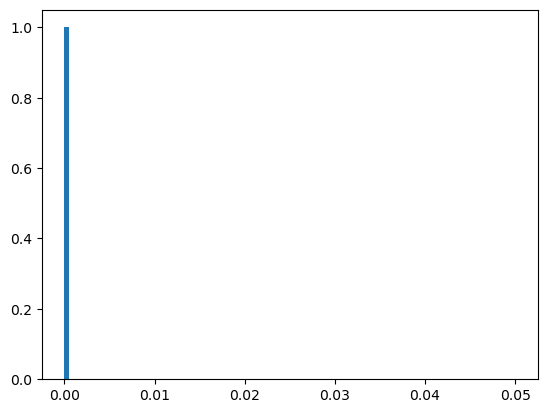

In [223]:
myarray=np.square(state_vectors[110])
weights = np.ones_like(myarray) / len(myarray)
plt.hist(np.abs(myarray),weights=weights, bins=100,range=[0,0.05],label='circuit')

## for porter thomas
# x = np.linspace(0, 0.05, 100)  # Create a range of x values from 0 to 1
# theoretical_distribution = [np.exp(-2**n * i) for i in x]  # Uniform distribution for example
# plt.plot(x, theoretical_distribution,label='Theoretical Distribution', color='red', linewidth=2)

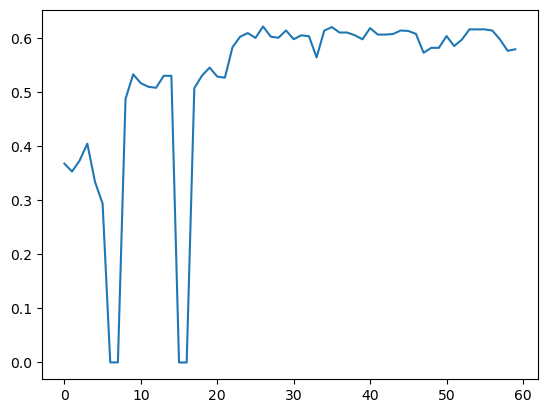

In [65]:
plt.plot(r_tildae_list)

In [ ]:
r_tildae_qiskit_prev,rdm_trash=get_r_tildae(qc_prev,partition=list(range(int(n/2))),simulator='qiskit')
dm_prev=DensityMatrix.from_instruction(qc_prev)
dm=DensityMatrix.from_instruction(qc)
prev_evalue=np.linalg.eigvals(dm_prev)
current_evalue=np.linalg.eigvals(dm)
print(r_tildae_qiskit_prev)


In [ ]:

##code to implement gates as per the dictionary 
exp_qc=qc_prev.copy()
for i in gates_added[0]:
    print(i)
    print(gates_added[0][i])
    if(gates_added[0][i]=='cnot'):
        j= i
        j = ast.literal_eval(j)
        exp_qc.cx(j[0],j[1])
    if(gates_added[0][i]=='s'):
        exp_qc.s(int(i))
    if(gates_added[0][i]=='h'):
        exp_qc.h(int(i))
        
    r_tildae_qiskit_exp,rdm_exp=get_r_tildae(exp_qc,partition=list(range(int(n/2))),simulator='qiskit')
    print(r_tildae_qiskit_exp)
